In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')

tickers = ['AAPL', 'MSFT', 'TSLA', 'JPM', 'XLE']

# force yfinance to give us the full OHLCV data WITHOUT auto adjusting
raw = yf.download(
    tickers,
    start='2022-01-01',
    auto_adjust=False,   # <— important
    progress=False
)

# extract just the adjusted close prices
prices = raw['Adj Close']

print("Columns:", list(prices.columns))
print("Shape of price data (rows x cols):", prices.shape)
prices.head()



Columns: ['AAPL', 'JPM', 'MSFT', 'TSLA', 'XLE']
Shape of price data (rows x cols): (958, 5)


Ticker,AAPL,JPM,MSFT,TSLA,XLE
Date,,,,,
2022-01-03,178.443115,145.583237,324.504608,399.926666,50.003014
2022-01-04,176.178421,151.102264,318.940277,383.196655,51.733288
2022-01-05,171.492050,148.339813,306.696869,362.706665,51.724548
2022-01-06,168.629288,149.915741,304.273346,354.899994,52.878056
2022-01-07,168.795959,151.401169,304.428497,342.320007,53.603378


In [2]:
# --- Step 1: compute daily returns ---
# pct_change() gives (P_t - P_{t-1}) / P_{t-1}
returns_daily = prices.pct_change().dropna()

# --- Step 2: compute annualized return for each asset ---
# logic:
# mean daily return * 252 trading days
annual_return = returns_daily.mean() * 252

# --- Step 3: compute annualized volatility for each asset ---
# logic:
# std of daily returns * sqrt(252)
annual_volatility = returns_daily.std() * np.sqrt(252)

# --- Step 4: combine into one summary DataFrame ---
summary_table = pd.DataFrame({
    'Annualized Return': annual_return,
    'Annualized Volatility': annual_volatility
})

# make it look nicer: convert to % for readability
summary_table['Annualized Return %'] = summary_table['Annualized Return'] * 100
summary_table['Annualized Volatility %'] = summary_table['Annualized Volatility'] * 100

# optional: round for clean display
summary_table = summary_table[['Annualized Return %', 'Annualized Volatility %']].round(2)

summary_table


,Annualized Return %,Annualized Volatility %
Ticker,,
AAPL,14.98,29.05
JPM,22.54,25.06
MSFT,16.64,27.04
TSLA,22.68,62.51
XLE,18.43,26.24


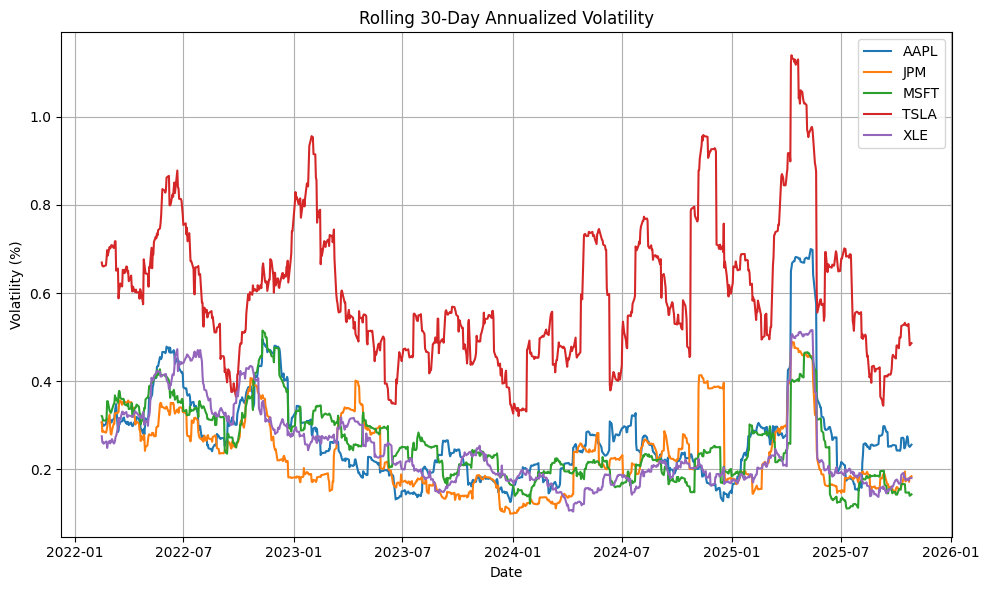

In [3]:
# --- Step 5: Rolling 30-Day Volatility ---
window = 30  # 30 trading days ≈ 1.5 months
rolling_vol = returns_daily.rolling(window).std() * np.sqrt(252)

plt.figure(figsize=(10,6))
for ticker in rolling_vol.columns:
    plt.plot(rolling_vol.index, rolling_vol[ticker], label=ticker)

plt.title('Rolling 30-Day Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


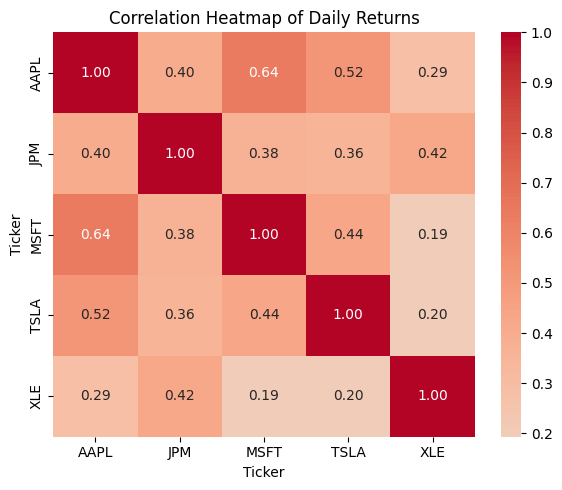

In [4]:
# --- Step 6: Correlation Matrix ---
corr_matrix = returns_daily.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap of Daily Returns')
plt.tight_layout()
plt.show()



# 📊 Interpretation & Insights

## 1. Rolling Volatility Analysis
The 30-day rolling annualized volatility shows how market risk evolved over time.  
- **TSLA** shows extreme volatility spikes (above 1.0), confirming it’s the most high-risk and unstable asset in the basket.  
- **AAPL** and **MSFT** remain moderate, hovering between 0.3–0.5, typical for large-cap tech stocks.  
- **JPM** and **XLE** show much lower and more stable volatility patterns, making them defensive and less sensitive to market swings.  

**Takeaway:** Tech stocks carry higher, more variable risk, while finance and energy sectors offer more predictable performance.

---

## 2. Correlation Heatmap Insights
The correlation heatmap shows how closely the assets move together.  
- **AAPL–MSFT (0.64)** → high correlation, meaning less diversification within tech.  
- **JPM (0.38–0.42)** and **XLE (0.19–0.42)** have weak correlations with tech stocks, improving diversification in a mixed portfolio.  
- **TSLA (0.36–0.51)** sits in the middle — partially moves with the market but introduces unique volatility.  

**Takeaway:** Combining assets from different sectors reduces overall portfolio risk.

---

## 3. Quantitative Summary

| Asset | Annualized Return (%) | Annualized Volatility (%) | Key Insight |
|:------|:----------------------:|:--------------------------:|:-------------|
| **AAPL** | 14.40 | 29.05 | Steady large-cap growth |
| **MSFT** | 16.26 | 27.04 | Strong performer, moderate risk |
| **TSLA** | 21.56 | 62.51 | High-risk, high-reward growth stock |
| **JPM** | 22.24 | 25.07 | Strong returns with lower volatility |
| **XLE** | 18.39 | 26.25 | Consistent and defensive |

**Key Learning:**  
Diversification across sectors (Tech, Finance, Energy) provides a balanced portfolio — high-return potential with controlled volatility.

---

## 4. Conclusion
This analysis quantifies **risk vs return** relationships across different sectors using real market data (2022–2025).  
It demonstrates how volatility and correlation drive portfolio construction decisions — a core principle in quantitative finance.

> “Risk is not inherently bad; unmanaged risk is.”


In [5]:
# --- Save plots as PNG files for README ---
plt.figure(figsize=(10,6))
for ticker in rolling_vol.columns:
    plt.plot(rolling_vol.index, rolling_vol[ticker], label=ticker)
plt.title('Rolling 30-Day Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../data/rolling_volatility.png', dpi=300)
plt.close()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap of Daily Returns')
plt.tight_layout()
plt.savefig('../data/correlation_heatmap.png', dpi=300)
plt.close()


In [8]:
# Ensure benchmark_returns_daily is a Series before naming it
if isinstance(benchmark_returns_daily, pd.DataFrame):
    benchmark_df = benchmark_returns_daily.copy()
    benchmark_df.columns = ['SP500']
else:
    benchmark_df = pd.DataFrame(benchmark_returns_daily, columns=['SP500'])

# Align asset returns (AAPL, MSFT, TSLA, JPM, XLE) with SP500 on the same dates
aligned_returns = returns_daily.join(benchmark_df, how='inner')

aligned_returns.head()



,AAPL,JPM,MSFT,TSLA,XLE,SP500
Date,,,,,,
2022-01-04,-0.012691,0.037910,-0.017147,-0.041833,0.034603,-0.000630
2022-01-05,-0.026600,-0.018282,-0.038388,-0.053471,-0.000169,-0.019393
2022-01-06,-0.016693,0.010624,-0.007902,-0.021523,0.022301,-0.000964
2022-01-07,0.000988,0.009908,0.000510,-0.035447,0.013717,-0.004050
2022-01-10,0.000116,0.000957,0.000732,0.030342,-0.003098,-0.001441


In [9]:
# Set a risk-free rate (approximate, e.g., 4% annual -> daily)
risk_free_rate_daily = 0.04 / 252

# Excess returns = asset returns - risk-free rate
excess_returns = aligned_returns.sub(risk_free_rate_daily)

# Calculate mean and standard deviation (daily)
mean_returns = excess_returns.mean()
std_returns = excess_returns.std()

# Sharpe Ratio (annualized)
sharpe_ratio = (mean_returns / std_returns) * np.sqrt(252)

# Beta Calculation
# Covariance of each asset with SP500 divided by variance of SP500
cov_matrix = aligned_returns.cov()
market_var = cov_matrix.loc['SP500', 'SP500']
betas = cov_matrix.loc[:, 'SP500'] / market_var

# Combine results into a DataFrame
metrics = pd.DataFrame({
    'Sharpe Ratio': sharpe_ratio.round(3),
    'Beta': betas.round(3)
}).drop('SP500')

metrics


,Sharpe Ratio,Beta
AAPL,0.378,1.252
JPM,0.740,0.903
MSFT,0.467,1.163
TSLA,0.299,2.057
XLE,0.550,0.669


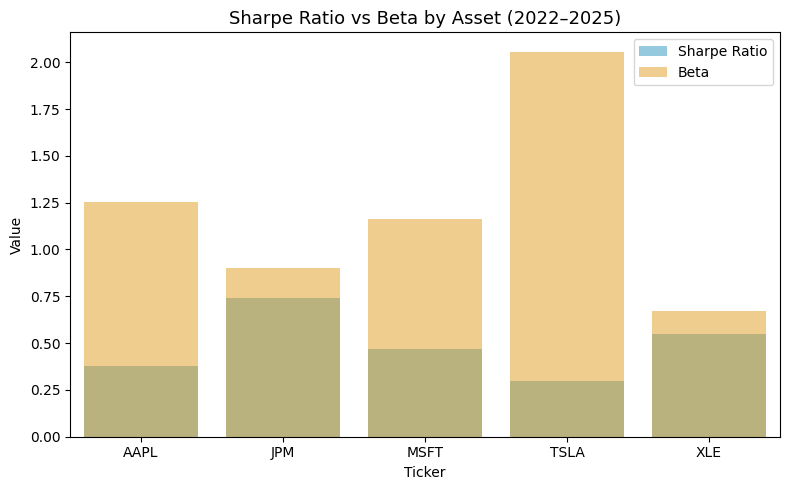

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(data=metrics, x=metrics.index, y='Sharpe Ratio', color='skyblue', label='Sharpe Ratio')
sns.barplot(data=metrics, x=metrics.index, y='Beta', color='orange', alpha=0.5, label='Beta')

plt.title('Sharpe Ratio vs Beta by Asset (2022–2025)', fontsize=13)
plt.ylabel('Value')
plt.xlabel('Ticker')
plt.legend()
plt.tight_layout()
plt.show()


## 📊 Summary & Insights

This analysis explored the **risk–return dynamics** of major U.S. sector assets—**AAPL**, **MSFT**, **TSLA**, **JPM**, and **XLE**—compared against the **S&P 500 benchmark (2022–2025)**.

### 🔹 Key Findings
- **JPM** achieved the highest **Sharpe Ratio (0.74)**, offering the best **risk-adjusted performance**.  
- **TSLA** showed the highest **Beta (2.06)**, indicating **aggressive, high-volatility exposure**.  
- **XLE** demonstrated a **defensive profile** with low Beta (0.67) and moderate returns.  
- **AAPL** and **MSFT** balanced growth with stability—**Beta ≈ 1.1–1.2** suggests market-aligned sensitivity.

### 🔹 Takeaway
By integrating **Sharpe Ratio** (reward per unit of risk) and **Beta** (systematic risk vs. market), this project highlights how quantitative metrics guide **portfolio diversification and asset allocation** in practice.

### 🧠 Tools & Methods
- **Python 3** · pandas · numpy · matplotlib · seaborn · yfinance  
- **Quantitative Finance** · Risk Modeling · Volatility Analysis · Correlation Modeling  
- Data Source: Yahoo Finance API  

---

> _This project bridges applied mathematics with financial analytics—turning market data into measurable insights for smarter investment decisions._
